In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#from startup import *
import sys,os,glob
import subprocess

sysconfig={}
sysconfig['ccalin004']={'base':'/mnt/ceph/users/ckim/','source':'/mnt/home/ckim/Sources/pyathena-TIGRESS/'}
sysconfig['tigressdata.princeton.edu']={'base':'/tigress/changgoo/','source':'/tigress/changgoo/pyathena-TIGRESS/'}
sysconfig['tigressdata2.princeton.edu']={'base':'/tigress/changgoo/','source':'/tigress/changgoo/pyathena-TIGRESS/'}
sysconfig['cori']={'base':'/global/cscratch1/sd/changgoo/','source':'/global/u2/c/changgoo/pyathena/'}
sysconfig['princeton-macbook']={'base':'/Users/ckim/Research/TIGRESS/','source':'/Users/ckim/Sources/pyathena-TIGRESS/'}

sysname=os.uname()[1]

if sysname in sysconfig:
    print('### setting up for %s system' % sysname)
    sys.path.insert(0,sysconfig[sysname]['source'])
    base=sysconfig[sysname]['base']
    sourcedir=sysconfig[sysname]['source']
    print('### base directory path is %s' % base)
else:
    print('### no system is matched with %s' % sysname)

#import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from matplotlib.colors import LogNorm,Normalize,SymLogNorm
import cmocean

### setting up for tigressdata2.princeton.edu system
### base directory path is /tigress/changgoo/


In [2]:
import matplotlib.pyplot as plt
# Figure
plt.rcParams['figure.figsize']=(8,6)
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.bbox']='tight'

# Font
plt.rcParams['font.size']=20
plt.rcParams['font.weight'] = 300

# Axes
plt.rcParams['axes.linewidth']=2
plt.rcParams['xtick.major.width']=2
plt.rcParams['ytick.major.width']=2
plt.rcParams['xtick.major.size']=5
plt.rcParams['ytick.major.size']=5

# Line
plt.rcParams['lines.linewidth']=2

# Image
plt.rcParams['image.origin']='lower'

In [3]:
import pyathena as pa
from pyathena.set_plt import *
import pandas as pd

In [55]:
labels={'phase3':'warm','phase4':'intermediate','phase5':'hot','whole':'whole'}
clist={'phase3':'C2','phase5':'C3','cold':'C0','phase4':'C1','whole':'C4'}

In [5]:
MFunit=units['massflux']
EFunit=(unit['density']*unit['velocity']**3).to('erg/s/kpc^2').value
pFunit=(unit['density']*unit['velocity']**2).to('M_sun*km/s/kpc^2/yr').value
EFunit2=(unit['density']*unit['velocity']**3).to('erg/Myr/pc^2').value
Myr=units['Myr']

In [6]:
class data_container(object):
    def __init__(self,zpdata,problem_id):
        self.problem_id=problem_id
        
        self.zpdata=zpdata
        self.t=self.zpdata.taxis
        self.tMyr=self.t*units['Myr']
        self.z=self.zpdata.zaxis
        surf_fact=(self.z[1]-self.z[0])*(unit['density']*unit['length']).to('Msun/pc^2').value
        self.zpw=zpdata.to_array().sum(dim='variable')
        self.surf=(self.zpw.loc['d']/self.zpw.loc['A']).sum(axis=0)*surf_fact
        
        self.read_all()
        
        par=self.par
        self.Lx=par['x1max']-par['x1min']
        self.Ly=par['x2max']-par['x2min']
        self.Lz=par['x3max']-par['x3min']
        self.hLz=self.Lz/2.
        self.Nz=int(par['Nx3'])
        self.hNz=self.Nz/2
        self.area=self.Lx*self.Ly
        
    def read_all(self):
        problem_id=self.problem_id
        self.hstfile='{}{}/hst/{}.hst'.format(base,problem_id,problem_id)
        self.hst=pa.hst_reader(self.hstfile)
        self.sn=pa.hst_reader(self.hstfile.replace('.hst','.sn'))
        self.par=pa.get_params(self.hstfile.replace('hst/','').replace('.hst','.par'))
    
    def select_trange(self,t1,t2):
        tMyr=self.tMyr
        self.tr=(tMyr > t1) & (tMyr < t2)
        self.t1=t1
        self.t2=t2
        
    def get_H(self):
        gas=self.zpw[:,:,self.tr]
        tt,zz=np.meshgrid(self.t[self.tr],self.z)
        self.H=np.sqrt((gas.loc['d']*zz**2).mean(axis=0)/gas.loc['d'].mean(axis=0))
        self.Hmean=self.H.mean()
        self.Hstd=self.H.std()
        self.zlist=np.arange(0,self.hLz,int(self.Hmean))
        
    def get_Nsn(self):
        Nsn10=[]
        Nsn20=[]
        Nsn40=[]
        for t in self.tMyr.data:
            sntMyr=self.sn['time']*Myr
            Nsn10.append(len(sntMyr[(sntMyr > t-10) & (sntMyr <= t)]))
            Nsn20.append(len(sntMyr[(sntMyr > t-20) & (sntMyr <= t)]))
            Nsn40.append(len(sntMyr[(sntMyr > t-40) & (sntMyr <= t)]))
        self.Nsn10=np.array(Nsn10)
        self.Nsn20=np.array(Nsn20)
        self.Nsn40=np.array(Nsn40)

In [7]:
def get_mean_std(q,z,symmetric=True,log=True,cumsum=False):
    if symmetric: sign=1 
    else: sign=-1
    pzidx=z>0
    mzidx=z<0
    qmean=np.nanmean(q,axis=1)
    qstd=np.nanstd(q,axis=1)
    #qmean=0.5*(qmean[pzidx]+sign*qmean[mzidx][::-1])
    #qstd=0.5*np.sqrt(qstd[pzidx]**2+qstd[mzidx][::-1]**2)
    zupper=z#[pzidx]
    if log:
        qmin,qmax=get_logerror(qmean,qstd)
#        idx=qmean > 0
#        qmin,qmax=get_logerror(qmean[idx],qstd[idx])
#        qmean=qmean[idx]
#        zupper=zupper[idx]
    else:
        qmin=qmean-qstd
        qmax=qmean+qstd
    
    return zupper,qmean,qstd,qmin,qmax

def get_logerror(q,dq):
    reldq=10.**(dq/q/np.log(10.))
    upper=q+dq#q*reldq
    lower=q/reldq
    return lower,upper

In [8]:
def plot_zprof_d(data,plist=['phase3','phase4','phase5'],t1=200,t2=500):
    zpw=data.zpw
    zpdata=data.zpdata
    gasw=zpw.sel(taxis=slice(t1,t2))
    z=zpw.zaxis/1.e3
    dz=zpw.zaxis[1]-zpw.zaxis[0]
    area=zpw.sel(fields='A').mean()
    fig,axes=plt.subplots(2,1,sharex=True)
    ax=axes[0]
    for p in plist:
        gas=zpdata[p].sel(taxis=slice(t1,t2))
        q=gas.sel(fields='d')/gas.sel(fields='A')
        zupper,qmean,qstd,qmin,qmax = get_mean_std(q,z)
        l,=ax.plot(zupper,qmean,label=labels[p],color=clist[p])
        ax.fill_between(zupper,qmin,qmax,color=l.get_color(),alpha=0.2)

    ax.legend(loc='upper right',fontsize='small',shadow=True)
    #plt.ylim(1.e-4,100.)
    ax.set_ylabel(r'$\langle n_H\rangle$ [${\rm cm^{-3}}$]')
    
    ax=axes[1]
    for p in plist:
        gas=zpdata[p].sel(taxis=slice(t1,t2))
        #q=gas.sel(fields='d')/area
        q=gas.sel(fields='A')/area
        zupper,qmean,qstd,qmin,qmax = get_mean_std(q,z)
        l,=ax.plot(zupper,qmean,label=labels[p],color=clist[p])
        ax.fill_between(zupper,qmin,qmax,color=l.get_color(),alpha=0.2)

    #plt.axvline(H,color='C6',ls=':')
    plt.setp(axes,'yscale','log')
    ax.set_xlabel(r'$z$ [${\rm kpc}$]')
    #ax.set_ylabel(r'$\langle n_H\rangle f_A [{\rm cm^{-3}}]$')
    ax.set_ylabel(r'$f_A $')
    
    return fig

In [9]:
def plot_surf(data):
    d=data
    problem_id=data.problem_id
    fig=plt.figure(figsize=(10,10))

    plt.subplot(211)
    plt.plot(d.tMyr,d.surf,label=problem_id)
    plt.plot(d.tMyr[d.tr],d.surf[d.tr])
    plt.xlabel('t [Myr]')
    plt.ylabel(r'$\Sigma\, [{\rm M_\odot pc^{-2}}]$')
    plt.legend()

    twoH=d.Hmean.data*2
    twoH=1000.
    pflux=d.zpw.sel(fields=['mFzd','pFzd'],zaxis=slice(twoH-50,twoH+50)).sum(dim='fields').mean(dim='zaxis')
    mflux=d.zpw.sel(fields=['mFzd','pFzd'],zaxis=slice(-twoH-50,-twoH+50)).sum(dim='fields').mean(dim='zaxis')
    Mflux1=(pflux-mflux)/d.area*units['massflux']

    plt.subplot(212)
    plt.plot(d.tMyr,Mflux1,'-',label='at d={:4.2f}kpc'.format(twoH/1.e3))
    plt.plot(d.tMyr[d.tr],Mflux1[d.tr])
    plt.plot(d.hst['time']*Myr,d.hst['sfr10'])

    plt.xlabel('t [Myr]')
    plt.ylabel(r'$\dot{\Sigma}_{\rm wind} [{\rm M_\odot pc^{-2} Myr^{-1}}]$')
    plt.legend()

    plt.tight_layout()
    return plt.gcf()

def plot_tevol(data):
        
# time evolution of mass and energy fluxes
    d=data
    problem_id=data.problem_id

    z=d.z
    Lz=d.Lz
    t=d.tMyr
    zlist=d.zlist
    dslab=10
    iwin=10
    gas=d.zpw

    h=d.hst
    sn=d.sn

    fig=plt.figure(figsize=(8,8))
    for j, z0 in enumerate(zlist[1:]):
        idx=(np.abs(z)<(z0+dslab))*(np.abs(z)>(z0-dslab))
        zz,tt=np.meshgrid(z[idx],t,indexing='ij')
        for i,flux in enumerate([gas['Mflux']*MFunit,gas['Eflux']*EFunit]):
            netflux=((flux/gas['A'])[idx]*np.sign(zz)).mean(axis=0)
            plt.subplot(2,1,i+1)
            plt.plot(t,netflux.rolling(iwin).mean(),label=r'$%3.1f $' % (z0/1.e3),color=cmap(z0/Lz*1.5))
    axes=fig.axes

    for ax in axes:
        ax.grid('off')
        ax.xaxis.set_ticks_position('both')
        ax.axhline(0,color='grey',ls=':')
    ax=axes[0]
    plt.setp(ax.get_xticklabels(),'visible',False)
    l2=axes[0].plot(h.time,h.sfr10.rolling(iwin).mean(),color='grey',lw=1,label=r'$\Sigma_{\rm SFR}$')
    ax.legend(l2,[r'$\Sigma_{\rm SFR}$'],shadow=True)
    ax.set_ylabel(r'mass flux,' + '\n'+r'$\dot{\Sigma}_{\rm wind}$ $[M_\odot{\rm \; yr^{-1}\; kpc^{-2}}]$')
    ax=axes[1]
    ax.set_ylabel(r'energy flux,' + '\n'+r'$\mathcal{F}_E$ $[{\rm erg\; s^{-1}\; kpc^{-2}}]$')
    ax.legend(loc=0,title=r'$d\;[{\rm kpc}]$',shadow=True)
    for ax, lab in zip(fig.axes,'abc'):
        ax.text(0.05,0.93,'(%s)' % lab,ha='left',va='top',transform=ax.transAxes,**pa.texteffect(18))

    plt.setp(axes[-1],'xlabel',r'time, $t\; [{\rm Myr}]$')
    for ax in axes:
        ax.axvspan(d.t1,d.t2,alpha=0.1,color='gray')
    fig.tight_layout()

    #fig.savefig('wind_fig/{}-flux_evol.png'.format(problem_id),bbox_inches='tight')

In [11]:
def plot_mass_flux(z,gas,area):
    hNz=len(z)/2
    zupper=z[hNz:]
    q=(gas.loc['M3']/area)*MFunit
    qp=(gas.loc['pFzd']/area)*MFunit
    qn=(gas.loc['mFzd']/area)*MFunit

    mf=np.array(q)
    mf=mf[hNz:,:]-mf[:hNz,:][::-1,:]
    outflow=np.array(qp)[hNz:,:]
    outflow2=-np.array(qn)[:hNz,:][::-1,:]
    inflow=np.array(qn)[hNz:,:]-np.array(qp)[:hNz,:][::-1,:]
    qmean=np.abs(mf.mean(axis=1))
    qstd=np.abs(mf.std(axis=1))
    qmin=qmean-qstd
    qmax=qmean+qstd
    qmin,qmax=get_logerror(qmean,qstd)
    l,=plt.plot(zupper,qmean,label='net flux')
    plt.fill_between(zupper,qmin,qmax,color=l.get_color(),alpha=0.2)
    plt.plot(zupper,outflow.mean(axis=1),label='outflow upper')
    plt.plot(zupper,outflow2.mean(axis=1),label='outflow lower')
    plt.plot(zupper,-inflow.mean(axis=1),label='inflow')
    plt.xlabel(r'distance from the midplane, $d\;[{\rm kpc}]$')
    plt.ylim(outflow.mean(axis=1).min()*0.1,outflow.mean(axis=1).max()*10.)

def plot_energy_flux(z,fluxes,area):
    hNz=len(z)/2
    zupper=z[hNz:]
    for Eflux,lab in zip(fluxes,['kinetic','enthalpy','magnetic','gravitational']):
        ef=np.array(Eflux/area)*EFunit
        ef=ef[hNz:,:]-ef[:hNz,:][::-1,:]
        qmean=np.abs(ef.mean(axis=1))
        qstd=np.abs(ef.std(axis=1))

        qmin,qmax=get_logerror(qmean,qstd)
        l,=plt.plot(zupper,qmean,label=lab)
        plt.fill_between(zupper,qmin,qmax,color=l.get_color(),alpha=0.2)
    plt.xlabel(r'distance from the midplane, $d\;[{\rm kpc}]$')

def plot_specific_energy(z,fluxes,Mflux,total=False):
    hNz=len(z)/2
    zupper=z[hNz:]
    qtot=np.zeros(len(zupper))
    mf=np.array(Mflux)
    mf=mf[hNz:,:]-mf[:hNz,:][::-1,:]
    qmean2=mf.mean(axis=1)
    qstd2=mf.std(axis=1)

    for Eflux,lab in zip(fluxes,['kinetic','enthalpy','magnetic','grav.']):
        ef=np.array(Eflux)
        ef=ef[hNz:,:]-ef[:hNz,:][::-1,:]
        qmean1=ef.mean(axis=1)
        qstd1=ef.std(axis=1)
        qmean=qmean1/qmean2
        qstd=qmean*np.sqrt((qstd1/qmean1)**2+(qstd2/qmean2)**2)
        qmin,qmax=get_logerror(qmean,qstd)
    #        qmin=qmean-qstd
    #        qmax=qmean+qstd
        if lab in ['kinetic','enthalpy']: qtot += qmean
        elif lab is 'grav.': qtot -= qmean
        l,=plt.plot(zupper,qmean,label=lab)
        plt.fill_between(zupper,qmin,qmax,color=l.get_color(),alpha=0.2)
        if lab is 'kinetic' or lab is 'grav.':
            v = np.sqrt(2.0*qmean)
        elif lab is 'enthalpy':
            v = np.sqrt(0.4*qmean)
        else:
            v = np.sqrt(qmean)
        v =v[zupper > zupper.max()/2.]

    if total: plt.plot(zupper,qtot,label=r'$\mathcal{B}$')
    plt.xlabel(r'distance from the midplane, $d\;[{\rm kpc}]$')

def plot_flux(data,ph='phase5'):
    d=data
    problem_id=d.problem_id
    fig=plt.figure(figsize=(12,5))
    gas=d.zpdata[ph][:,:,d.tr]
    gasw=d.zpw[:,:,d.tr]
    z=d.z/1.e3
    H=d.Hmean/1.e3
    # mass flux
    plt.subplot(1,2,1)

    plot_mass_flux(z,gas,d.area)
    plt.yscale('log')
    plt.ylabel(r'mass flux,' + '\n' + r'$|\dot{\Sigma}_{{\rm wind},h}|$ $[M_\odot{\rm\; yr^{-1}\; kpc^{-2} }]$')
    plt.axvline(H,color='C6',ls=':')

    fluxes=get_Eflux(gas)
    # specific energy
    plt.subplot(1,2,2)
    plot_specific_energy(z,fluxes,gas.loc['M3'],total=True)
    plt.yscale('log')
    plt.ylim(1.e2,2.e6)
    plt.ylabel(r'specific energy,'+'\n'+r'$\mathcal{F}_{E,h}/\dot{\Sigma}_{{\rm wind},h}$ $[{\rm km^2\;s^{-2}}]$')
    plt.axvline(H,color='C6',ls=':')

    axes=fig.axes
    for ax, lab in zip(fig.axes,'abcd'):
        ax.text(0.05,0.93,'(%s)' % lab,ha='left',va='top',transform=ax.transAxes,**pa.texteffect(18))

    axes[0].legend(shadow=True)
    axes[1].legend(ncol=2,loc='lower right',shadow=True)
    plt.tight_layout()
    #plt.setp(axes,'xlim',(0,2.0))
    #plt.savefig('wind_fig/{}-{}_flux.png'.format(problem_id,ph),bbox_inches='tight')
    return plt.gcf()
    
def get_Eflux(zp):
    KEflux=zp.sel(fields=['pFzE1','pFzE2','pFzE3','mFzE1','mFzE2','mFzE3']).sum(dim='fields')
    TEflux=zp.sel(fields=['pFzP','mFzP']).sum(dim='fields')
    BEflux=zp.sel(fields=['pSzEm1','pSzEm2','pSzvB1','pSzvB2','mSzEm1','mSzEm2','mSzvB1','mSzvB2']).sum(dim='fields')
    GEflux=zp.sel(fields=['pFzEge','pFzEgsg','pFzEtidal','mFzEge','mFzEgsg','mFzEtidal']).sum(dim='fields')
    return KEflux,TEflux,BEflux,GEflux

In [13]:
def plot_loading(data,plist=['phase3','phase5']):
    import astropy.units as u
    import astropy.constants as c
    d=data
    
    problem_id=d.problem_id
    
    h=d.hst
    sn=d.sn

    tbin=d.tr
    tMyr=d.tMyr
    t1=d.t1
    t2=d.t2
    hNz=d.hNz
    zupper=d.z[d.hNz:]/1.e3
    Lx=d.Lx
    Ly=d.Ly

    sntidx=(sn.time*Myr > tMyr[tbin].data.min()) & (sn.time*Myr < tMyr[tbin].data.max())
    print(len(sn[sntidx]),len(tMyr[tbin]))
    Nsn=np.histogram(sn[sntidx].time*Myr,range=[t1,t2],bins=len(tMyr[tbin]))

    snrate=Nsn[0]/np.diff(Nsn[1])/u.Myr
    sn_mrate=(10.*c.M_sun*snrate/((Lx*Ly)*u.pc**2)).to('M_sun/yr/kpc^2').value
    sn_erate=(1.e51*u.erg*snrate/((Lx*Ly)*u.pc**2)).to('erg/s/kpc^2').value

    sfr10=np.interp(tMyr[tbin],h.time*Myr,h.sfr10)
    sfr40=np.interp(tMyr[tbin],h.time*Myr,h.sfr40)
    sfr100=np.interp(tMyr[tbin],h.time*Myr,h.sfr100)

    area=d.Lx*d.Ly
    fig=plt.figure(figsize=(12,5))
    plt.subplot(121)
    for p in plist:
        gas=d.zpdata[p][:,:,tbin]
        pmf=np.array(gas.loc['pFzd'])*MFunit/area
        mmf=np.array(gas.loc['mFzd'])*MFunit/area
        mf=pmf[hNz:,:]-mmf[:hNz,:][::-1,:]
        qmean=mf.mean(axis=1)/sfr10.mean()
        qstd=mf.std(axis=1)/sfr10.mean()
        qmin,qmax=get_logerror(qmean,qstd)
        l,=plt.plot(zupper,qmean,color=clist[p],label=labels[p])
        plt.fill_between(zupper,qmin,qmax,color=l.get_color(),alpha=0.2)
#         mf=np.array(gas.loc['M3'])*MFunit/area
#         mf2=mf[hNz:,:]-mf[:hNz,:][::-1,:]
#         qmean=mf2.mean(axis=1)/sfr10.mean()
#         qstd=mf2.std(axis=1)/sfr10.mean()
#         qmin,qmax=get_logerror(qmean,qstd)
#         l,=plt.plot(zupper,qmean,color=clist[p],label=labels[p]+' net')

        #print p,qmean[1000],qmean[250],qmean[1000]/qmean[250]
    plt.yscale('log')
    #plt.xlim(0,4)
    plt.ylim(5.e-3,20)

    plt.xlabel(r'distance from the midplane [kpc]')
    plt.ylabel(r'mass loading factor')# +'\n'+ r'$\beta\equiv \dot{\Sigma}_{\rm wind}^+/\Sigma_{\rm SFR}$')
    plt.axvline(d.Hmean/1.e3,color='C6',ls=':')
    plt.legend(loc=0,shadow=True)


    plt.grid('off')
    plt.subplot(122)
    for p in plist:
        gas=d.zpdata[p][:,:,tbin]
        pef=np.array(gas.sel(fields=['pFzE1','pFzE2','pFzE3','pFzP']).sum(dim='fields'))*EFunit/area
        mef=np.array(gas.sel(fields=['mFzE1','mFzE2','mFzE3','mFzP']).sum(dim='fields'))*EFunit/area
        ef=pef[hNz:,:]-mef[:hNz,:][::-1,:]
        qmean=ef.mean(axis=1)/sn_erate.mean()
        qstd=ef.std(axis=1)/sn_erate.mean()
        qmin,qmax=get_logerror(qmean,qstd)
        l,=plt.plot(zupper,qmean,color=clist[p],label=labels[p])
        plt.fill_between(zupper,qmin,qmax,color=l.get_color(),alpha=0.2)
        #print p,qmean[1000],qmean[250],qmean[1000]/qmean[250]
    plt.xlabel(r'distance from the midplane [kpc]')
    plt.ylabel(r'energy loading factor')# +'\n'+
#               r'$\alpha\equiv (\mathcal{F}_{\rm KE}^++\mathcal{F}_{\rm TE}^+)/(E_{\rm SN}\Sigma_{\rm SFR}/m_*)$')
    #plt.xlim(0,4)
    plt.yscale('log')
    #plt.ylim(1.e-4,1)
    plt.axvline(d.Hmean/1.e3,color='C6',ls=':')
    plt.grid('off')
    #for ax, lab in zip(fig.axes,'abcd'):
    #    ax.text(0.85,0.93,'(%s)' % lab,ha='left',va='top',transform=ax.transAxes,**pa.texteffect(18))
    axes=fig.axes
    #plt.setp(axes,'xlim',(0,4))
    plt.tight_layout()
    #plt.savefig('wind_fig/{}-loadings.png'.format(problem_id),bbox_inches='tight')
    return plt.gcf()


In [14]:
outdir='/tigress/changgoo/public_html/TIGRESS_outflow/figures/'

In [20]:


def plot_pflux_tz(data):
    fig, axes=plt.subplots(4,1,gridspec_kw={'height_ratios':[1,2,2,2],'hspace':0.},figsize=(10,10),sharex=True)

    ax=axes[0]
    ax.plot(data.hst['time']*Myr,data.hst['sfr10'],label='')
    ax.plot(data.hst['time']*Myr,data.hst['sfr40'],label='')
    sfrmean=data.hst['sfr10'].mean()
    ax.set_ylabel(r'$\Sigma_{\rm SFR}$')
    for ph,ax in zip(['phase3','phase4','phase5'],axes[1:]):
        gas=data.zpdata[ph]
        pflux=np.array(gas.sel(fields=['pFzM3','mFzM3']).sum(dim='fields'))*pFunit/data.area
        im=ax.pcolormesh(data.tMyr,data.z/1.e3,pflux,cmap=plt.cm.RdBu_r)
        ax.text(0.02,0.9,labels[ph],va='center',transform=ax.transAxes,**pa.texteffect(20))
    axes[1].fill_between(data.tMyr,data.H/1.e3,-data.H/1.e3,color='y',alpha=0.6)
    axes[1].fill_between(data.tMyr,2*data.H/1.e3,-2*data.H/1.e3,color='y',alpha=0.3)
    x0,y0,xl,yl=ax.get_position().bounds
    cax=fig.add_axes([x0+xl,y0,0.02,yl*3])
    cbar=fig.colorbar(im,cax=cax,label=r'Momentum Flux')
    ax.set_xlabel('t [Myr]')
    plt.setp(axes[1:],'ylabel','z [kpc]')
    ax.set_xlim(0,data.tMyr.max())
    return fig

def plot_Eflux_tz(data):
    fig, axes=plt.subplots(4,1,gridspec_kw={'height_ratios':[1,2,2,2],'hspace':0.},figsize=(10,10),sharex=True)

    ax=axes[0]
    ax.plot(data.hst['time']*Myr,data.hst['sfr10'],label='')
    ax.plot(data.hst['time']*Myr,data.hst['sfr40'],label='')
    #Mflux=data.zpdata['phase5'].sel(fields=['pFzd','mFzd']).sum(dim='fields')/data.area*MFunit
    # H=data.Hmean
    # ax.plot(data.tMyr,10.*Mflux.sel(zaxis=slice(2*H-50,2*H+50)).mean(dim='zaxis'))
    # ax.legend()
    sfrmean=data.hst['sfr10'].mean()
    sneratemean=(1.e51*u.erg*(sfrmean/100./u.kpc**2/u.yr)).to('erg/s/kpc^2').value
    ax.set_ylabel(r'$\Sigma_{\rm SFR}$')
    for ph,ax in zip(['phase3','phase4','phase5'],axes[1:]):
        gas=data.zpdata[ph]
        pef=np.array(gas.sel(fields=['pFzE1','pFzE2','pFzE3','pFzP']).sum(dim='fields'))*EFunit/data.area
        mef=np.array(gas.sel(fields=['mFzE1','mFzE2','mFzE3','mFzP']).sum(dim='fields'))*EFunit/data.area
        Eflux=pef+mef
        im=ax.pcolormesh(data.tMyr,data.z/1.e3,Eflux,cmap=plt.cm.RdBu_r,vmin=-0.1*sneratemean,vmax=0.1*sneratemean)
        ax.text(0.02,0.9,labels[ph],va='center',transform=ax.transAxes,**pa.texteffect(20))
    #axes[1].plot(data.tMyr,data.H/1.e3,color='y')
    #axes[1].plot(data.tMyr,-data.H/1.e3,color='y')
    axes[1].fill_between(data.tMyr,data.H/1.e3,-data.H/1.e3,color='y',alpha=0.6)
    #axes[1].plot(data.tMyr,2*data.H/1.e3,color='y')
    #axes[1].plot(data.tMyr,-2*data.H/1.e3,color='y')
    axes[1].fill_between(data.tMyr,2*data.H/1.e3,-2*data.H/1.e3,color='y',alpha=0.3)
    x0,y0,xl,yl=ax.get_position().bounds
    cax=fig.add_axes([x0+xl,y0,0.02,yl*3])
    cbar=fig.colorbar(im,cax=cax,label=r'Energy Flux')
    ax.set_xlabel('t [Myr]')
    plt.setp(axes[1:],'ylabel','z [kpc]')
    ax.set_xlim(0,data.tMyr.max())
    return fig

In [16]:
def plot_tz(data,var='Mflux',clabel=None,cmap=plt.cm.RdBu_r,cbar_type='one'):
    fig, axes=plt.subplots(4,1,gridspec_kw={'height_ratios':[1,2,2,2],'hspace':0.},figsize=(10,10),sharex=True)

    ax=axes[0]
    ax.plot(data.hst['time']*Myr,data.hst['sfr10'],label='')
    ax.plot(data.hst['time']*Myr,data.hst['sfr40'],label='')

    sfrmean=data.hst['sfr10'].mean()
    sneratemean=(1.e51*u.erg*(sfrmean/100./u.kpc**2/u.yr)).to('erg/s/kpc^2').value
    ax.set_ylabel(r'$\Sigma_{\rm SFR}$')
    
    for ph,ax in zip(['phase3','phase4','phase5'],axes[1:]):
        if var == 'Mflux':
            tzdata=data.zpdata[ph].sel(fields=['pFzd','mFzd']).sum(dim='fields')/data.area*MFunit
            vmin=-0.3*sfrmean
            vmax=0.3*sfrmean
            log=False
        elif var == 'Eflux':
            gas=data.zpdata[ph]
            pef=np.array(gas.sel(fields=['pFzE1','pFzE2','pFzE3','pFzP']).sum(dim='fields'))*EFunit/data.area
            mef=np.array(gas.sel(fields=['mFzE1','mFzE2','mFzE3','mFzP']).sum(dim='fields'))*EFunit/data.area
            tzdata=pef+mef
            vmin=-0.1*sneratemean
            vmax=0.1*sneratemean
            log=False
        elif var =='pflux':
            tzdata=data.zpdata[ph].sel(fields=['pFzM3','mFzM3']).sum(dim='fields')/data.area*pFunit
            vmin=None
            vmax=None
            log=False
        elif var == 'fA':
            tzdata=data.zpdata[ph].sel(fields='A')/data.area
            vmin=0.0
            vmax=1
            log=False
        elif var == 'vz':
            tzdata=data.zpdata[ph].sel(fields='M3')/data.zpdata[ph].sel(fields='d')
            vmax=tzdata.mean(dim='taxis').max()*2
            vmin=-vmax
            log=False
        elif var == 'P':
            tzdata=data.zpdata[ph].sel(fields='P')/data.zpdata[ph].sel(fields='A')*units['P']
            vmax=1.e5*(sfrmean/1.e-2)
            vmin=1.e1*(sfrmean/1.e-2)
            log=True
        elif var == 'fM':
            tzdata=data.zpdata[ph].sel(fields='d')/data.zpw.sel(fields='d')
            vmin=0
            vmax=1
            log=False

        im=ax.pcolormesh(data.tMyr,data.z/1.e3,tzdata,cmap=cmap,vmin=vmin,vmax=vmax)
        
        if log:
            im.set_norm(LogNorm(vmin=vmin,vmax=vmax))
        ax.text(0.02,0.9,labels[ph],va='center',transform=ax.transAxes,**pa.texteffect(20))
        if cbar_type == 'each':
            x0,y0,xl,yl=ax.get_position().bounds
            cax=fig.add_axes([x0+xl,y0,0.02,yl])
            if clabel is None: clabel=var
            cbar=fig.colorbar(im,cax=cax,label=clabel)

    axes[2].fill_between(data.tMyr,data.H/1.e3,-data.H/1.e3,color='y',alpha=0.6)
    axes[2].fill_between(data.tMyr,2*data.H/1.e3,-2*data.H/1.e3,color='y',alpha=0.3)
    if cbar_type == 'one':
        x0,y0,xl,yl=ax.get_position().bounds
        cax=fig.add_axes([x0+xl,y0,0.02,yl*3])
        if clabel is None: clabel=var
        cbar=fig.colorbar(im,cax=cax,label=clabel)
    ax.set_xlabel('t [Myr]')
    plt.setp(axes[1:],'ylabel','z [kpc]')
    ax.set_xlim(0,data.tMyr.max())
    return fig

In [17]:
import pyathena.preprocessing as pre
pid='MHD_4pc_new'


In [18]:
zpdata=pre.merge_xarray(base,pid,pid)
data=data_container(zpdata,pid)
data.select_trange(-1,data.tMyr.max()+1)
data.get_H()

Reading a history file:/tigress/changgoo/MHD_4pc_new/hst/MHD_4pc_new.hst.p
Reading a history file:/tigress/changgoo/MHD_4pc_new/hst/MHD_4pc_new.sn.p


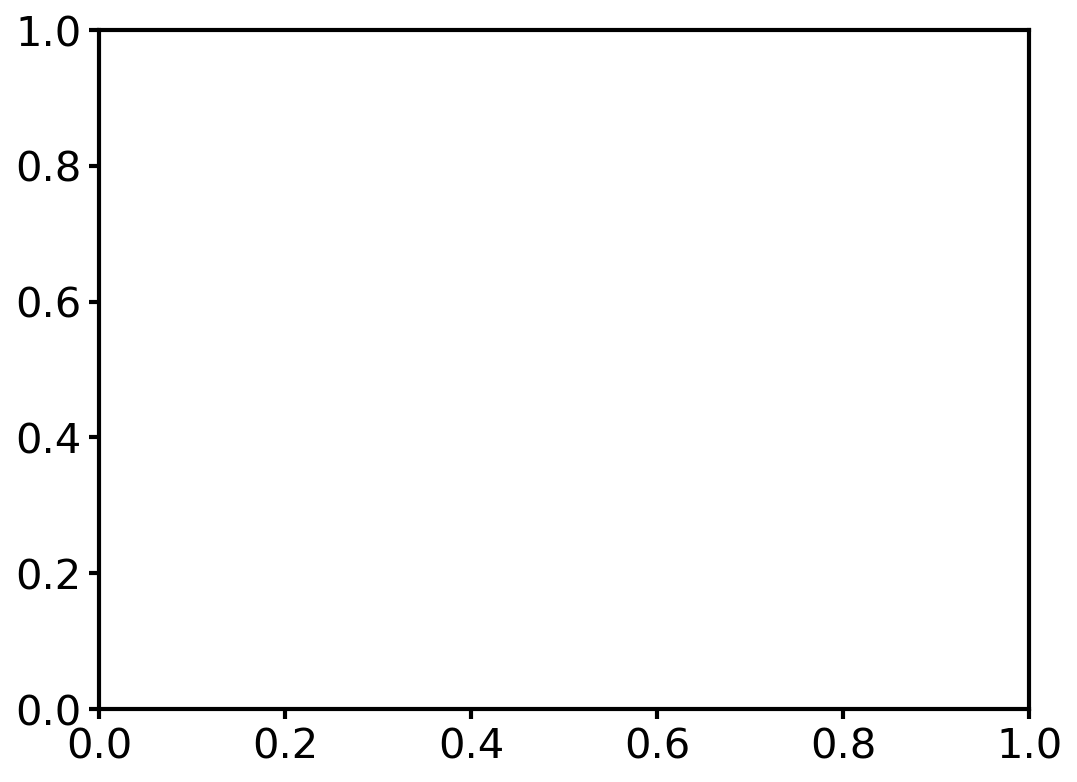

In [42]:

ax=plt.gca()


In [68]:
sfr=data.hst['sfr10'][(data.hst['time']*Myr >200) & (data.hst['time']*Myr < 500)]

In [73]:
print(sfr.mean(),sfr.std())
q1,q2,q3=sfr.quantile([0.1,0.5,0.9])
print(q2,q3-q2,q2-q1)

0.00420413957257329 0.003672902823773987
0.0030017585 0.0053074045 0.002125798


In [82]:
def plot_Mflux_tz(data):
    fig, axes=plt.subplots(4,1,gridspec_kw={'height_ratios':[2,2,2,2],'hspace':0.},figsize=(10,12),sharex=True)

    ax=axes[0]
    ax.plot(data.hst['time']*Myr,data.hst['sfr10'],label='')
    ax.plot(data.hst['time']*Myr,data.hst['sfr40'],label='')
    #Mflux=data.zpdata['phase5'].sel(fields=['pFzd','mFzd']).sum(dim='fields')/data.area*MFunit
    # H=data.Hmean
    # ax.plot(data.tMyr,10.*Mflux.sel(zaxis=slice(2*H-50,2*H+50)).mean(dim='zaxis'))
    # ax.legend()
    sfrmean=data.hst['sfr10'].mean()
    ax.set_ylabel(r'$\Sigma_{\rm SFR}$'+'\n'+r'$[{\rm M_\odot\,kpc^{-2}\,yr^{-1}}]$')
    ax.set_yscale('log')
    ax.set_ylim(5.e-4,5.e-2)
    for ph,ax in zip(['phase3','phase4','phase5'],axes[1:]):
        Mflux=data.zpdata[ph].sel(fields=['pFzd','mFzd']).sum(dim='fields')/data.area*MFunit
        im=ax.pcolormesh(data.tMyr,Mflux.zaxis/1.e3,Mflux,cmap=cmocean.cm.balance)
        im.set_norm(SymLogNorm(1.e-3,vmin=-1.e-1,vmax=1.e-1))
        
        ax.text(0.02,0.9,labels[ph],va='center',transform=ax.transAxes,**pa.texteffect(20))
    #axes[1].plot(data.tMyr,data.H/1.e3,color='y')
    #axes[1].plot(data.tMyr,-data.H/1.e3,color='y')
    #axes[1].fill_between(data.tMyr,data.H/1.e3,-data.H/1.e3,color='y',alpha=0.6)
    #axes[1].plot(data.tMyr,2*data.H/1.e3,color='y')
    #axes[1].plot(data.tMyr,-2*data.H/1.e3,color='y')
    #axes[1].fill_between(data.tMyr,2*data.H/1.e3,-2*data.H/1.e3,color='y',alpha=0.3)
    for ax in axes:
        ax.axvspan(0,200,color='k',alpha=0.3)
        ax.axvspan(500,700,color='k',alpha=0.3)
    x0,y0,xl,yl=ax.get_position().bounds
    cax=fig.add_axes([x0+xl,y0,0.02,yl*3])
    cbar=fig.colorbar(im,cax=cax,label=r'Mass Flux'+'\n'+r'$[{\rm M_\odot\,kpc^{-2}\,yr^{-1}}]$')
    ax.set_xlabel('t [Myr]')
    plt.setp(axes[1:],'ylabel','z [kpc]')
    ax.set_xlim(0,data.tMyr.max())
    return fig

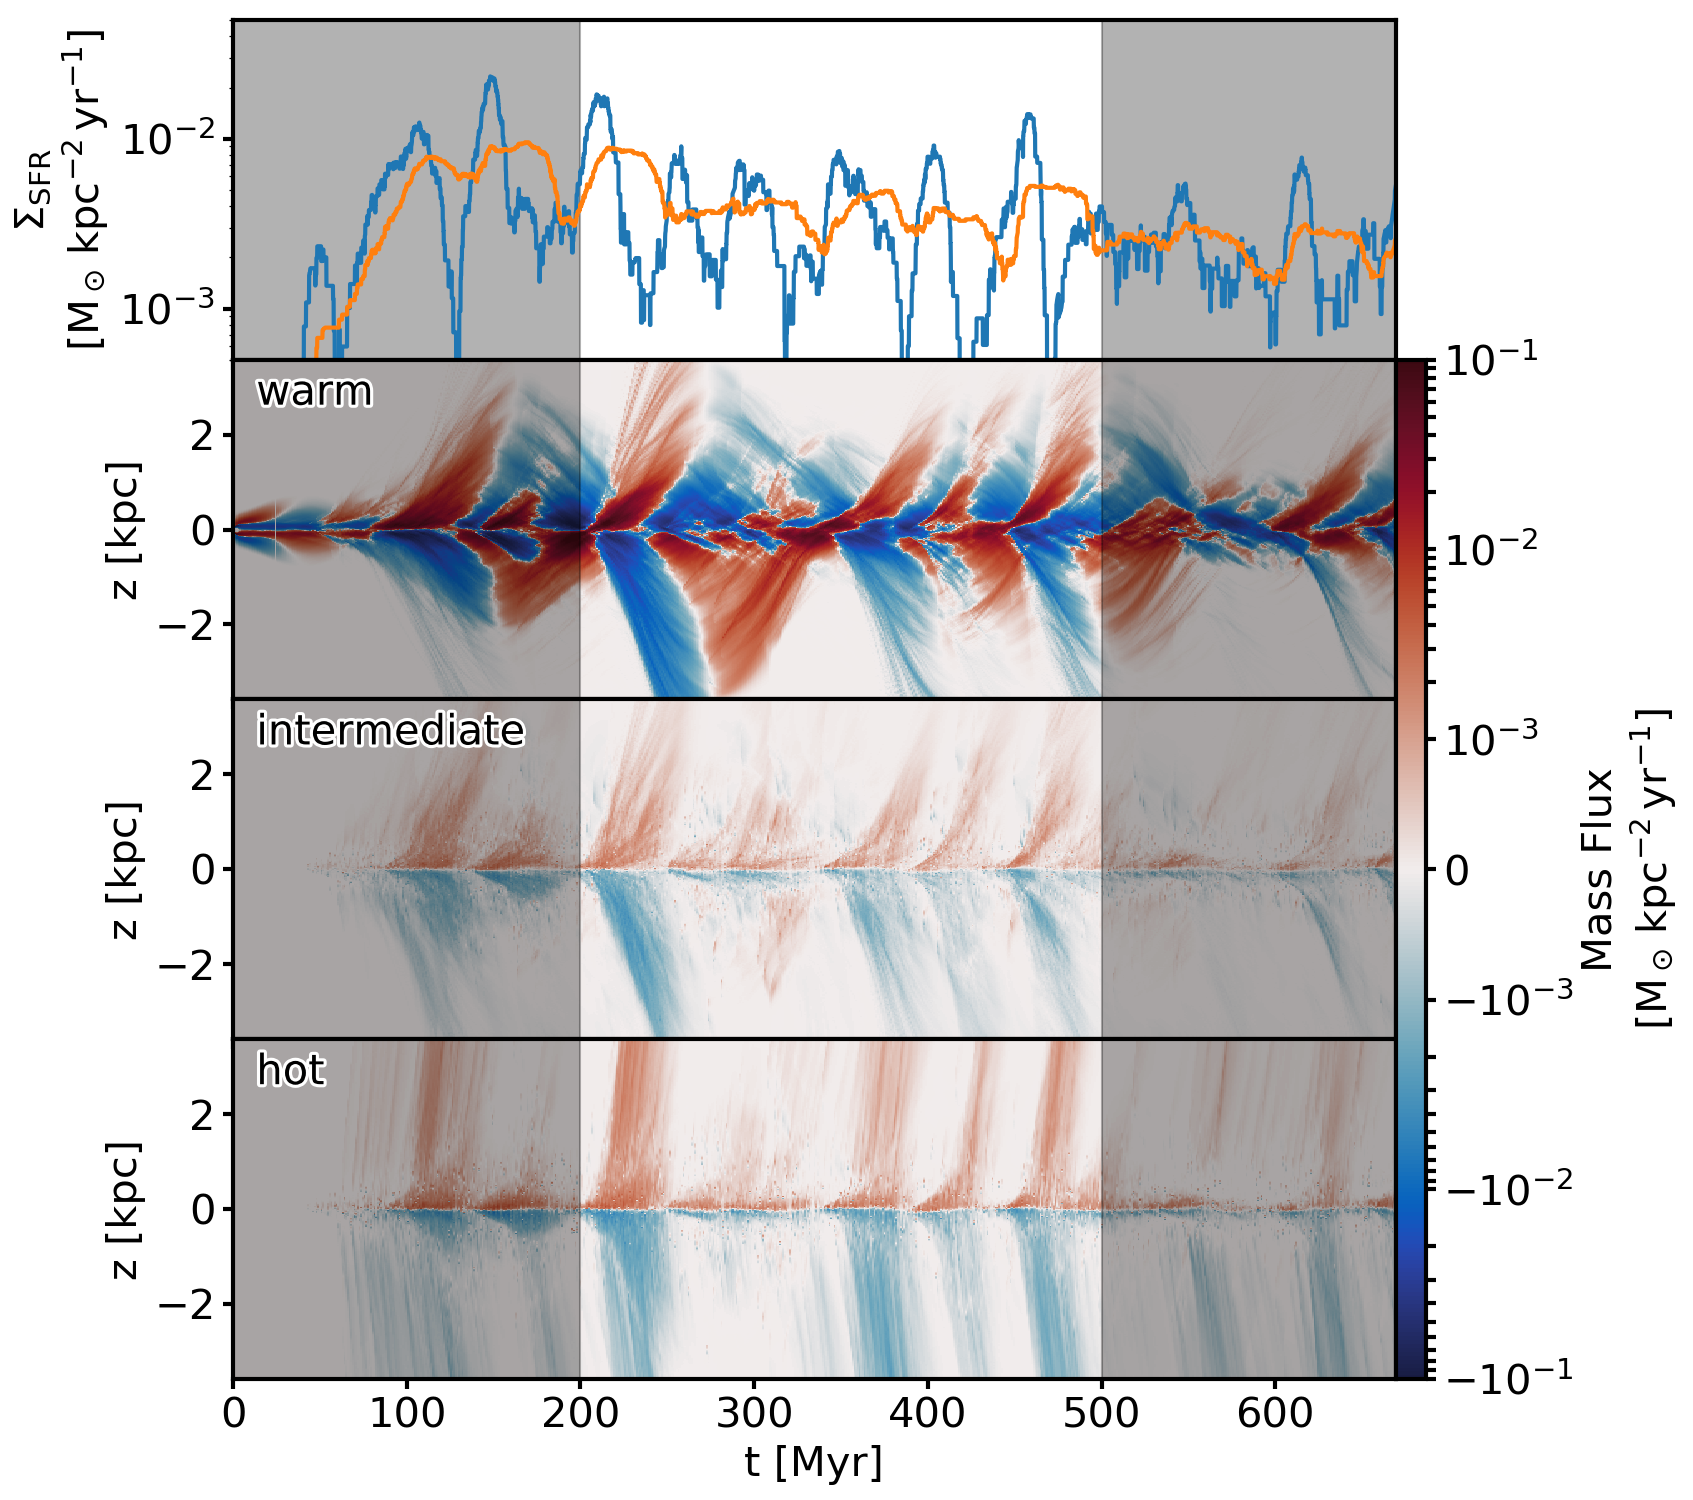

In [83]:
fig=plot_Mflux_tz(data)


In [84]:
fig.savefig('{}/Mflux_tz.png'.format(outdir))
fig.savefig('{}/Mflux_tz.pdf'.format(outdir))

In [26]:
pdfdir='{}{}/vel_pdf/'.format(base,pid)

In [27]:
pdfdir

'/tigress/changgoo/MHD_4pc_new/vel_pdf/'

In [46]:
import glob,os
wpdf=glob.glob(pdfdir+'*.w.mpdf')
ipdf=glob.glob(pdfdir+'*.i.mpdf')
hpdf=glob.glob(pdfdir+'*.h.mpdf')

In [47]:
import cPickle as p
wpdf.sort()
ipdf.sort()
hpdf.sort()

In [39]:
pdf['mpdf']

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [43]:
pdf['vbin']

array([-1000.    ,  -992.1875,  -984.375 ,  -976.5625,  -968.75  ,
        -960.9375,  -953.125 ,  -945.3125,  -937.5   ,  -929.6875,
        -921.875 ,  -914.0625,  -906.25  ,  -898.4375,  -890.625 ,
        -882.8125,  -875.    ,  -867.1875,  -859.375 ,  -851.5625,
        -843.75  ,  -835.9375,  -828.125 ,  -820.3125,  -812.5   ,
        -804.6875,  -796.875 ,  -789.0625,  -781.25  ,  -773.4375,
        -765.625 ,  -757.8125,  -750.    ,  -742.1875,  -734.375 ,
        -726.5625,  -718.75  ,  -710.9375,  -703.125 ,  -695.3125,
        -687.5   ,  -679.6875,  -671.875 ,  -664.0625,  -656.25  ,
        -648.4375,  -640.625 ,  -632.8125,  -625.    ,  -617.1875,
        -609.375 ,  -601.5625,  -593.75  ,  -585.9375,  -578.125 ,
        -570.3125,  -562.5   ,  -554.6875,  -546.875 ,  -539.0625,
        -531.25  ,  -523.4375,  -515.625 ,  -507.8125,  -500.    ,
        -492.1875,  -484.375 ,  -476.5625,  -468.75  ,  -460.9375,
        -453.125 ,  -445.3125,  -437.5   ,  -429.6875,  -421.8

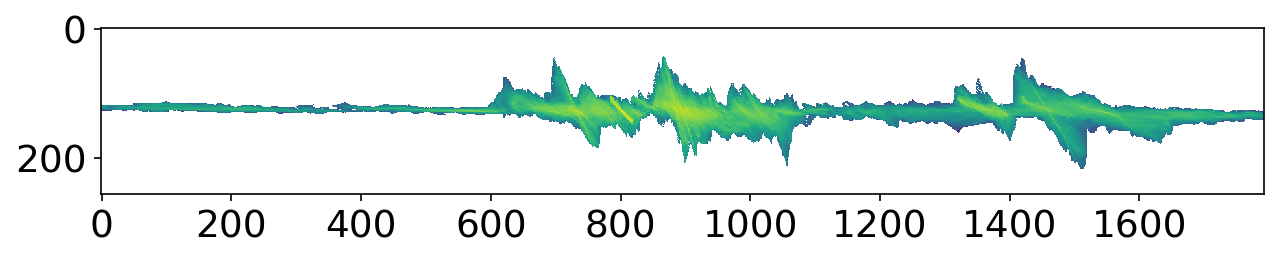

In [45]:
plt.imshow(pdf['mpdf'][4],norm=LogNorm())

In [34]:
pdf

,-1500.0,-1490.0,-1480.0,-1470.0,-1460.0,-1450.0,-1440.0,-1430.0,-1420.0,-1410.0,...,1400.0,1410.0,1420.0,1430.0,1440.0,1450.0,1460.0,1470.0,1480.0,1490.0
-3582.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-3578.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-3574.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-3570.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-3566.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-3562.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-3558.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-3554.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-3550.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-3546.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
vpdf=[]
mpdf=[]
for itime in range(100,200):
    pdf=p.load(open('{}{}.{:04d}.pdf'.format(outdir,pid,itime),'rb'))
    vpdf.append(pdf['vpdf'])
    mpdf.append(pdf['mpdf'])